In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy

### Read data from RxRespone-survey-202507

In [3]:
path = r"D:\TNUSummerSchool\Astronomy\RadioInterfemeterProject\RxResponse-survey-202507\20250620_104832-Meifeng-LPDA-up-EW-FEM_BPF200_750-ref-10-atten10.csv"
data = pd.read_csv(path)
data.head()

,No,Freq(Hz),Ampt_Trace1(dBm),Ampt_Trace2(dBm),Ampt_Trace3(dBm),Ampt_Trace4(dBm),Ampt_Trace5(dBm),Loc
0,1,1415657,-59.04,-58.95,-59.12,0.0,0.0,(0 0)
1,2,2416558,-75.18,-73.12,-76.12,0.0,0.0,(0 0)
2,3,3417459,-73.61,-73.28,-75.37,0.0,0.0,(0 0)
3,4,4418360,-74.02,-73.24,-75.44,0.0,0.0,(0 0)
4,5,5419261,-74.67,-73.83,-76.02,0.0,0.0,(0 0)


In [4]:
#information about the data
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   No                 1000 non-null   int64  
 1    Freq(Hz)          1000 non-null   int64  
 2    Ampt_Trace1(dBm)  1000 non-null   float64
 3    Ampt_Trace2(dBm)  1000 non-null   float64
 4    Ampt_Trace3(dBm)  1000 non-null   float64
 5    Ampt_Trace4(dBm)  1000 non-null   float64
 6    Ampt_Trace5(dBm)  1000 non-null   float64
 7    Loc               1000 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 62.6+ KB
None
                No      Freq(Hz)   Ampt_Trace1(dBm)   Ampt_Trace2(dBm)  \
count  1000.000000  1.000000e+03        1000.000000        1000.000000   
mean    500.500000  5.013657e+08         -59.823070         -56.305540   
std     288.819436  2.890796e+08           9.247558          12.529314   
min       1.000000  1.415657e+06         -75.340000

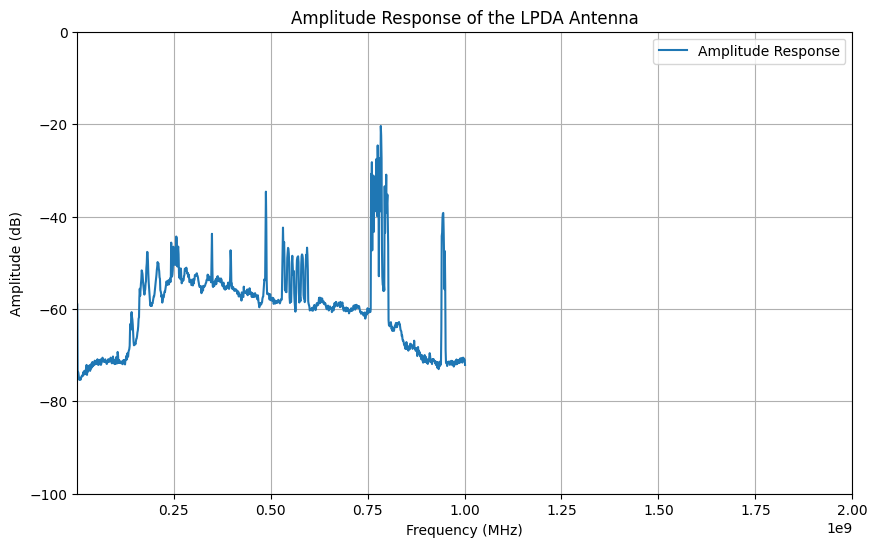

In [9]:
# read and plot the data
plt.figure(figsize=(10, 6))
plt.plot(data[' Freq(Hz)'], data[' Ampt_Trace1(dBm)'], label='Amplitude Response')
plt.title('Amplitude Response of the LPDA Antenna')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude (dB)')
plt.grid()
plt.legend()
plt.xlim(1.4e6, 2e9)
plt.ylim(-100, 0)
plt.show()


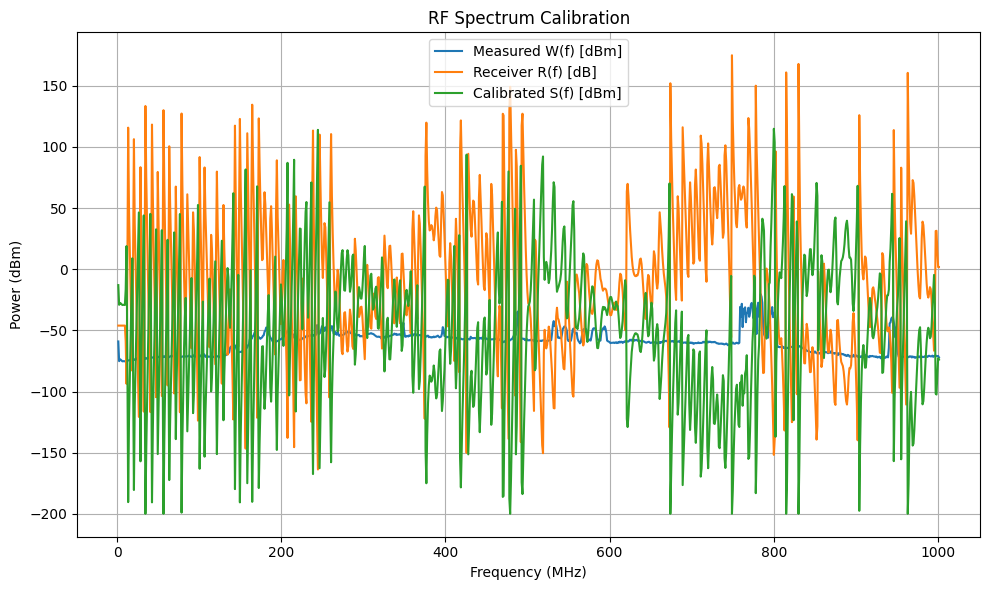

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step A: Load the noise spectrum CSV ===
csv_data = pd.read_csv(r"D:\TNUSummerSchool\Astronomy\RadioInterfemeterProject\RxResponse-survey-202507\20250620_104832-Meifeng-LPDA-up-EW-FEM_BPF200_750-ref-10-atten10.csv")

# === Step B: Load the S2P file and extract frequency + S21 magnitude ===
s2p_path = r"D:\TNUSummerSchool\Astronomy\RadioInterfemeterProject\RxResponse-survey-202507\CFD400-013-19M-SURVEY.S2P"

s2p_data = []
with open(s2p_path, 'r') as f:
    for line in f:
        line = line.strip()
        # Skip comments and headers
        if line.startswith('!') or line.startswith('#') or len(line) == 0:
            continue
        parts = line.split()
        if len(parts) >= 3:
            freq = float(parts[0])      # Hz
            s21_db = float(parts[2])    # S21 magnitude in dB
            s2p_data.append((freq, s21_db))

s2p_df = pd.DataFrame(s2p_data, columns=[" Freq(Hz)", " S21_dB"])

# === Step C: Interpolate the receiver response R(f) at each measurement frequency and calibrate ===
def db_to_linear(db):
    return 10 ** (db / 10)

def linear_to_db(lin):
    lin = np.clip(lin, 1e-20, None)  # Avoid log(0)
    return 10 * np.log10(lin)

# Interpolate S21_dB to match CSV frequencies
interp_s21 = np.interp(csv_data[" Freq(Hz)"], s2p_df[" Freq(Hz)"], s2p_df[" S21_dB"])

# Convert to linear scale
W_f_linear = db_to_linear(csv_data[" Ampt_Trace1(dBm)"])
R_f_linear = db_to_linear(interp_s21)

# Estimate S(f) = W(f) / R(f)
S_f_linear = W_f_linear / R_f_linear
S_f_db = linear_to_db(S_f_linear)

# Add to DataFrame for plotting
csv_data[" Calibrated_S(f)_dB"] = S_f_db

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(csv_data[" Freq(Hz)"]/1e6, csv_data[" Ampt_Trace1(dBm)"], label="Measured W(f) [dBm]")
plt.plot(csv_data[" Freq(Hz)"]/1e6, interp_s21, label="Receiver R(f) [dB]")
plt.plot(csv_data[" Freq(Hz)"]/1e6, S_f_db, label="Calibrated S(f) [dBm]")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dBm)")
plt.title("RF Spectrum Calibration")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


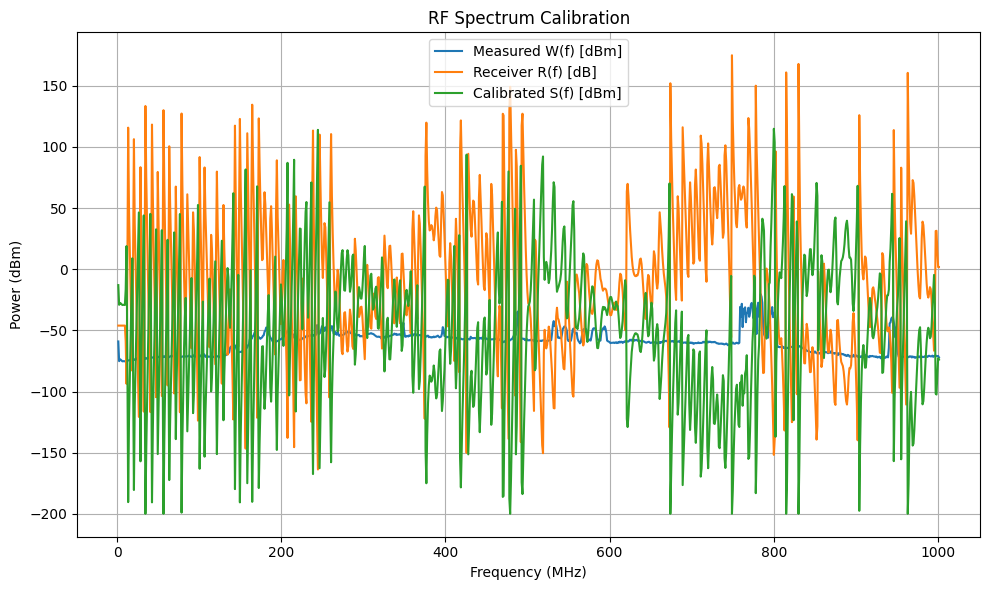

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step A: Load the noise spectrum CSV ===
csv_path = r"D:\TNUSummerSchool\Astronomy\RadioInterfemeterProject\RxResponse-survey-202507\20250620_104832-Meifeng-LPDA-up-EW-FEM_BPF200_750-ref-10-atten10.csv"  # <-- chỉnh lại đường dẫn file thật
csv_data = pd.read_csv(csv_path)

# Đảm bảo đúng tên cột
if "Freq(Hz)" not in csv_data.columns:
    csv_data.columns = ["No", "Freq(Hz)", "Ampt_Trace1(dBm)", "Ampt_Trace2(dBm)", "Ampt_Trace3(dBm)", "Ampt_Trace4(dBm)", "Ampt_Trace5(dBm)", "Loc"]

# === Step B: Load and parse the S2P file ===
s2p_path = r"D:\TNUSummerSchool\Astronomy\RadioInterfemeterProject\RxResponse-survey-202507\CFD400-013-19M-SURVEY.S2P"  # <-- chỉnh lại đường dẫn file thật

s2p_data = []
with open(s2p_path, 'r') as f:
    for line in f:
        line = line.strip()
        if line.startswith('!') or line.startswith('#') or line == "":
            continue  # skip header and comment lines
        try:
            values = list(map(float, line.split()))
            freq_hz = values[0]
            s21_db = values[2]  # S21 magnitude in dB
            s2p_data.append((freq_hz, s21_db))
        except ValueError:
            continue  # skip malformed lines

s2p_df = pd.DataFrame(s2p_data, columns=["Freq(Hz)", "S21_dB"])

# === Step C: Interpolate the receiver response R(f) at each measurement frequency and calibrate ===

def db_to_linear(db):
    return 10 ** (db / 10)

def linear_to_db(lin):
    lin = np.clip(lin, 1e-20, np.inf)  # avoid log(0)
    return 10 * np.log10(lin)

# Interpolate S21_dB to match CSV frequencies
interp_s21 = np.interp(csv_data["Freq(Hz)"], s2p_df["Freq(Hz)"], s2p_df["S21_dB"])

# Convert W(f) and R(f) to linear scale
W_f_linear = db_to_linear(csv_data["Ampt_Trace1(dBm)"])
R_f_linear = db_to_linear(interp_s21)

# Estimate S(f) = W(f) / R(f)
S_f_linear = W_f_linear / R_f_linear
S_f_db = linear_to_db(S_f_linear)

# Add to DataFrame for plotting
csv_data["Receiver R(f) [dB]"] = interp_s21
csv_data["Calibrated_S(f)_dB"] = S_f_db

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(csv_data["Freq(Hz)"]/1e6, csv_data["Ampt_Trace1(dBm)"], label="Measured W(f) [dBm]")
plt.plot(csv_data["Freq(Hz)"]/1e6, csv_data["Receiver R(f) [dB]"], label="Receiver R(f) [dB]")
plt.plot(csv_data["Freq(Hz)"]/1e6, csv_data["Calibrated_S(f)_dB"], label="Calibrated S(f) [dBm]")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dBm)")
plt.title("RF Spectrum Calibration")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
